- 学修番号: 21445095
- 氏名: 小田龍司

# 課題 1.2　ロジスティック回帰分析

ロジスティック回帰のインスタンス作成時のオプション指定：
- C=10000.0 を指定すること `LogisticRegression(C=10000.0)`
- 必要に応じて適当な値の max_iter も指定すること `LogisticRegression(C=10000.0, max_iter=100000)`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

autos = pd.read_csv('data/imports-85.data', na_values='?')
autos.columns = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
                    'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
                    'wheel_base', 'length','width', 'height', 'curb_weight',
                    'engine_type', 'num_of_cylinders', 'engine_size', 'fuel_system',
                    'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm',
                    'city_mpg', 'highway_mpg','price']
# 表示する最大列数の設定
pd.set_option('display.max_columns', len(autos.columns))
# 欠損値 NaN がある行の除去
autos = autos.dropna()
# 確認
autos

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
2,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
3,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
5,1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0
7,1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0
9,2,192.0,bmw,gas,std,two,sedan,rwd,front,101.2,176.8,64.8,54.3,2395,ohc,four,108,mpfi,3.50,2.80,8.8,101.0,5800.0,23,29,16430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
200,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
201,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
202,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


<hr>

### 1.2.1 市街地での燃費の良し悪しと馬力との関係

autos から city_mpg, highway_mpg 列を除外したうえで、city_mpgから中央値よりも大きければ1、小さいか等しければ0を値としたcity_mpg_01列を追加した pandas DataFrame を作成しなさい。

そのDataFrameについて、X軸を horsepower , Y軸を height として、city_mpg_01で色分けをした散布図を作成しなさい。

<AxesSubplot:xlabel='horsepower', ylabel='height'>

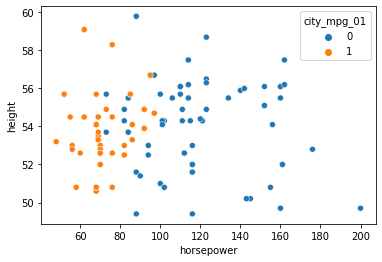

In [2]:
# 中央値
city_mpg_median = autos.city_mpg.median()

df = autos.drop(['city_mpg','highway_mpg'], axis=1)
# city_mpg_01列にcity_mpgダミー変数代入: 中央値よりも大きければ1、小さいか等しければ0
df['city_mpg_01'] = autos['city_mpg'].map(lambda x: 1 if x > city_mpg_median else 0)
df['city_mpg_01']

# 散布図
sns.scatterplot(data=df, x=df.horsepower, y=df.height ,hue='city_mpg_01')

<hr>

### 1.2.2 馬力からの燃費の良し悪しの予測

horsepower を説明変数, city_mpg_01 を目的変数とするロジスティック回帰モデルを作成し、AUC値を求め、また回帰係数 β_0 (切片), β_1 (傾き) を表示しなさい。<br>
AUC, 回帰係数ともに、小数点以下4桁目を四捨五入し、小数点以下3桁まで答えること（0.7625ならば0.763が答え）。

In [3]:
# ロジスティック回帰モデルを作成
model = LogisticRegression(C=10000.0)

 # 説明変数、目的変数
X = df[['horsepower']]
Y = df.city_mpg_01
model.fit(X, Y)

# ROC曲線, AUC
from sklearn.metrics import roc_curve, auc

Y_proba = model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
print('AUC= {:.3f}'.format(auc(fpr, tpr)))

# 回帰係数 β_0 (切片), β_1 (傾き)
β_0 = model.intercept_[0]
β_1 = model.coef_[0][0]
print('β_0={:.3f}, β_1={:.3f}'.format(β_0, β_1))

AUC= 0.963
β_0=14.133, β_1=-0.160


<hr>

### 1.2.3 燃費の良し悪しと他の原因との関係

horsepower, curb_weight, aspiration を説明変数、city_mpg_01 を目的変数とするロジスティック回帰モデルを作成し、
1. AUC値を求めなさい。<br>
小数点以下4桁目を四捨五入し、小数点以下3桁まで答えること（0.7625ならば0.763が答え）。
2. aspiration が turbo かそうではないかのそれぞれについて、作成したモデルに対する説明変数の値として curb_weight は中間値に固定したうえで、X軸に horsepower をとり最小値から最大値まで変化させ、Y軸に city_mpg_01=1 になる確率（シグモイド曲線）をグラフで描画しなさい。
  - グラフが turbo かそうではないかわかるように、色分けして表示すること。
  - できれば legend を付けること。付けられなければ、コメントやMarkdownのセルに文章を記載し補足すること。
3. 結果を考察しなさい。

AUC= 0.965


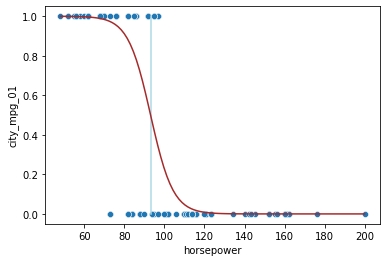

In [4]:
x_labels = ['horsepower', 'curb_weight', 'aspiration']

# ロジスティック回帰モデルを作成
model = LogisticRegression(C=10000.0)

 # 説明変数、目的変数
X = df[x_labels]
X = pd.get_dummies(data=X, drop_first=True)
Y = df.city_mpg_01
model.fit(X, Y)

# ROC曲線, AUC
Y_proba = model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
print('AUC= {:.3f}'.format(auc(fpr, tpr)))

# 散布図
sns.scatterplot(x=X.iloc[:,0], y=Y)

# パラメータ
b0 = model.intercept_[0]
b1 = model.coef_[0][0]

# y=0.5となる分割線
boundary = -b0 / b1
plt.plot([boundary, boundary], [0, 1], color='lightblue')

# シグモイド曲線
_max = X.iloc[:,0].max()
_min = X.iloc[:,0].min()
_step = (_max - _min) / 100
_X = np.arange(_min, _max + _step, _step)
plt.plot(_X, 1/(1 + np.exp(-(b0 + b1 * _X))), color='brown')

# 考察
AUC= 0.965であり、ロジスティック回帰の分類精度としては高いように見えるが、
シグモイド曲線が緩やかなことからaspiration、curb_weightの間に強い相関があり、
多重共線性により予測精度が落ちている
